In [2]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split

from multiprocessing import cpu_count

# Oversampling

**Unbalanced problems** are those classification problems where the ratio between the different classes is significantly different. These problems have some special issues that make them a little bit more difficult to solve. In particular, the choice of metric should account for this class imbalance, and some extra steps should be carried out to avoid the model focusing too much on the most frequent classes and performing poorly over the least frequent ones.

We will focus here on the binary classification problem, where you have a **majority class** and a **minority class**. For instance, the healthcare classification problem we worked on previous classes could be considered an unbalanced problem as the ratio of exitus (minority class) is approximately 5%. Other example would be the fraud detection problem at Iberia Express, where the minority class (fraud transaction) never exceeds 0.2% of the data, which is a ratio that would be considered a real unbalanced classification problem.

Metrics that can be applied to unbalanced problems are the ones based on the area under a curve. We have already seen ROC curve and precision-recall curve. From this two, area under the precision-recall curve is slightly preferred when dealing with highly unbalanced problems.

Regarding the extra pre-processing steps that can be carried out to help model solve unbalanced problems, we will cover **oversampling** of the **minority class** and **subsampling** of the **majority class**. We **focus here on oversampling**.

## Load Data

This is the method to load local files into Google Colab

In [3]:
import io
dat = pd.read_csv(('../data/healthcare.csv'), sep = ";")
dat = dat.drop(['date', 'severity', 'origin', 'tip_grd', 'tip_adm'], axis = 1) # Remove non-numerical variables for this notebook
dat

,mortality_ratio,age,num_proc,ambulatory,expected_length,exitus
0,0.408730,12596,21,0,151,0
1,0.306931,20973,22,0,99,0
2,0.278481,19611,19,0,87,0
3,0.150289,13583,22,0,100,0
4,0.016573,18042,2,0,44,0
...,...,...,...,...,...,...
32701,0.028365,23619,2,0,2,0
32702,0.000606,3935,1,0,2,0
32703,0.040452,30163,4,0,2,0
32704,0.000000,29012,4,0,0,0


Is **ambulatory a numerical variable**?

In [4]:
100*dat.groupby(['exitus'])['exitus'].agg(['count'])/dat.shape[0]

,count
exitus,
0,96.159726
1,3.840274


This can be considered an unbalanced classification problem. Let's see how to apply oversampling to it.

## Duplicated examples

One straightforward way of increasing the minority class examples is to just create duplicates of the existing minority class instances.

At first thought, this could seem not really helpful, as you are just repeating information. However, this can allow you to make the model focus more on the minority classes, giving more importance to a minority class example than to a majority class one. It would be like applying different weights to each row, depending of it belonging to one class or the other.

This can easily done with pandas sample function.

In [ ]:
?dat.sample

In [5]:
dat['exitus'].value_counts()

exitus
0    31450
1     1256
Name: count, dtype: int64

In [6]:
oversampling_ratio = 0.25
oversampling_rows = dat[dat['exitus'] == 1].sample(int(0.25*dat[dat['exitus'] == 0].shape[0]),
                                                                      replace = True,
                                                                      random_state = 0,
                                                                      axis = 0)

In [7]:
oversampling_rows.shape

(7862, 6)

In [8]:
dat_duplicates = pd.concat([dat, oversampling_rows])
100*dat_duplicates.groupby(['exitus'])['exitus'].agg(['count'])/dat_duplicates.shape[0]

,count
exitus,
0,77.524157
1,22.475843


In [9]:
dat['exitus'].value_counts()

exitus
0    31450
1     1256
Name: count, dtype: int64

In [10]:
dat_duplicates['exitus'].value_counts()

exitus
0    31450
1     9118
Name: count, dtype: int64

We have reduced the target unbalance.

## SMOTE

Synthetic Minority Oversampling TEchnique, **SMOTE**, is a really popular and useful oversampling technique. Its goal is to creat synthetic examples of the minority class, based on the distribution of the available examples of that class in the dataset.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (default k=5). A randomly selected neighbor is chosen from those k and a synthetic example is created at a randomly selected point between the two examples in feature space.

Visually SMOTE can be illustrated as the following:

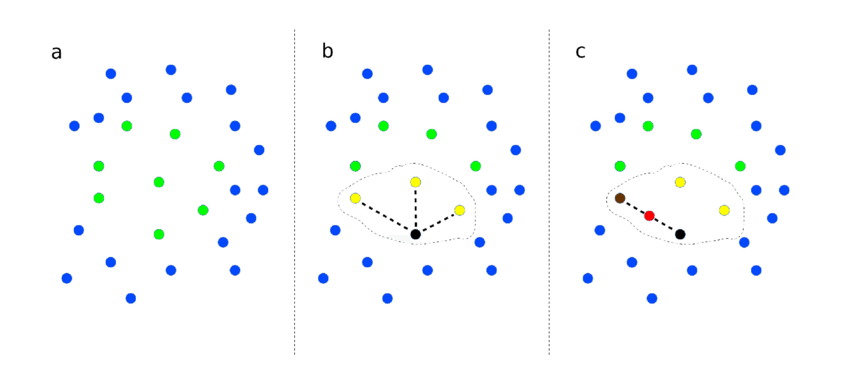

It is available in the package *imbalanced-learn*.

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
sm = SMOTE(sampling_strategy = 1.0,
           random_state = 0,
           k_neighbors = 5)

In [13]:
X_res, y_res = sm.fit_resample(dat.drop('exitus', axis = 1).fillna(0), dat['exitus'])

In [14]:
dat_smote = pd.concat([X_res, y_res], axis = 1)
100*dat_smote.groupby(['exitus'])['exitus'].agg(['count'])/dat_smote.shape[0]

,count
exitus,
0,50.0
1,50.0


In [15]:
dat['exitus'].value_counts()

exitus
0    31450
1     1256
Name: count, dtype: int64

In [16]:
dat_smote['exitus'].value_counts()

exitus
0    31450
1    31450
Name: count, dtype: int64

## Model Example

Let's work now with an artificial dataset.

In [17]:
from sklearn.datasets import make_classification

In [ ]:
?make_classification

In [18]:
X, y = make_classification(n_samples=1000,
                           n_features = 20,
                           weights=[0.99],
                           flip_y=0,
                           random_state=14)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.761381,-0.726303,-0.882760,0.482442,-0.018408,0.616003,-1.287714,0.156845,0.764001,0.165752,-0.505031,-0.554505,-1.012232,2.104490,-1.861749,0.429889,-0.298592,0.437592,-0.165739,-0.293814
1,-1.898984,0.598479,-2.115828,-0.212588,-0.546183,0.145231,-0.433949,0.491958,-0.310234,0.062804,0.543121,-0.045148,1.054995,1.831132,1.135055,0.024680,-1.621294,-0.270492,0.309067,-2.011508
2,1.080229,1.436528,-0.863406,0.821463,-0.042686,1.057408,0.617294,0.068706,0.174762,1.342367,-0.614906,-0.500036,0.649808,0.181521,0.614657,0.232352,-1.149416,-1.263655,1.077031,-0.544096
3,0.286519,-0.904983,-0.120506,1.606508,-0.541059,2.411908,-1.329881,1.305476,0.204597,-0.887442,0.233612,1.406151,-0.574740,0.558940,0.449324,0.756007,-1.101714,0.314365,-0.161759,-2.831481
4,-1.269741,1.027771,0.236196,-0.616071,-0.435511,-0.441575,-1.215510,-0.496491,-0.099667,0.187553,0.063099,-0.377577,-0.631351,0.277286,-1.596203,-0.236960,1.571108,-0.190075,0.540855,-1.397771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2.372752,0.241199,0.388543,-0.536196,-0.566138,-0.243683,-0.161078,-2.809955,-0.846728,0.206688,0.708719,0.734700,1.186080,2.290898,-2.457200,0.396356,-0.825902,-1.365043,-1.083094,-1.939196
996,0.064441,0.198146,2.239809,1.169356,-0.303320,1.687558,0.731075,0.071424,1.019326,1.334239,0.191406,-0.930340,-1.335235,-0.702962,0.288802,-0.375476,-0.369240,1.394828,0.176314,-1.711403
997,0.662398,-0.150583,1.080613,-0.983825,-0.397135,-0.929440,-1.630183,1.288452,1.619819,-0.472825,-0.151867,-1.631699,-0.965601,-0.613015,-1.360247,1.237631,1.143489,-1.576581,1.079393,-1.079772
998,0.589724,-0.248740,-1.667112,0.561053,-0.021237,0.716249,-0.263175,-0.505227,0.186734,-0.297017,-0.895176,-0.747946,-1.012003,-0.368098,1.871081,-1.024363,-0.765756,0.363201,-0.754536,-0.341030


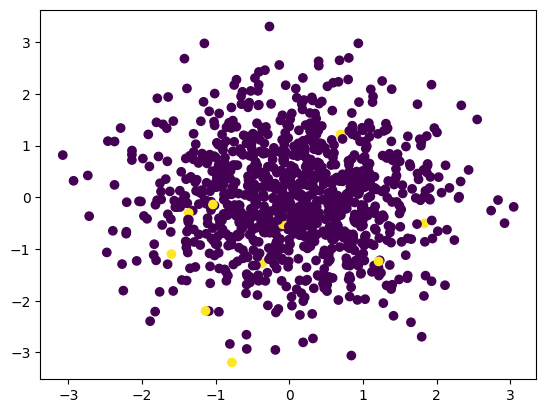

In [19]:
# scatter plot of examples by class label
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

In [20]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1  10]]


Let's apply SMOTE over this dataset.

In [21]:
sm = SMOTE(sampling_strategy = 0.2,
           random_state = 0,
           k_neighbors = 5)

In [22]:
X_smote, y_smote = sm.fit_resample(X, y)

J:\IE\SECOND TERM\MLII\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "J:\IE\SECOND TERM\MLII\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [23]:
unique, counts = np.unique(y_smote, return_counts=True)
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1 198]]


And build models with and without oversampling.

Model over the **original dataset**.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=1);

In [25]:
# 1) Import model
from sklearn.linear_model import LogisticRegression as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# [3] Define model
model = model_constructor(penalty = 'l1',
                          solver = 'liblinear',
                          C = 1,
                          random_state = 0)

# [4] Train model
model.fit(X_train, y_train) ## Only train!!! Requires target y for being supervised learning.

# [5] Predict
pred_train = model.predict_proba(X_train)
pred_test = model.predict_proba(X_test)

# [6] Compute metric
metric_train = metric(y_train, pred_train[:,1])
metric_test = metric(y_test, pred_test[:,1])

Dataset **after SMOTE**.

In [26]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, stratify = y_smote, test_size=0.3, random_state=1);


In [27]:
# 1) Import model
from sklearn.linear_model import LogisticRegression as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# [3] Define model
model = model_constructor(penalty = 'l1',
                          solver = 'liblinear',
                          C = 1,
                          random_state = 0)

# [4] Train model
model.fit(X_smote_train, y_smote_train) ## Only train!!! Requires target y for being supervised learning.

# [5] Predict
pred_train = model.predict_proba(X_smote_train)
pred_test = model.predict_proba(X_smote_test)

# [6] Compute metric
metric_smote_train = metric(y_smote_train, pred_train[:,1])
metric_smote_test = metric(y_smote_test, pred_test[:,1])

Let's **compare** both approaches.

In [28]:
# print error
print('AUC train = %.2f - AUC test = %.2f'
      % (metric_train, metric_test))

# print error SMOTE
print('AUC SMOTE train = %.2f - AUC SMOTE test = %.2f'
      % (metric_smote_train, metric_smote_test))

AUC train = 1.00 - AUC test = 0.63
AUC SMOTE train = 0.99 - AUC SMOTE test = 0.99


## Define Custom Function

Let's create our own custom function to apply oversampling using smote or duplicates.

In [29]:
def oversampling(X, y, p, type_value = 'SMOTE', k = 5, random_state = 0, n_jobs = 1):
    if type_value == 'SMOTE':
        sm = SMOTE(sampling_strategy = p,
           random_state = random_state,
           k_neighbors = k)
        X, y = sm.fit_resample(X, y)
        return X, y
    elif type_value == 'duplicates':
        majority_class = stats.mode(y, keepdims = False)[0]
        oversampling_rows = pd.concat([pd.DataFrame(X[y != majority_class]),
                                       pd.Series(y[y != majority_class])],
                                      axis = 1).sample(frac = p,
                                                                      replace = True,
                                                                      random_state = random_state,
                                                                      axis = 0)
        X = pd.concat([pd.concat([pd.DataFrame(X), pd.Series(y)], axis = 1), oversampling_rows])
        y = X.iloc[:, X.shape[1]-1]
        return X, y


In [30]:
unique, counts = np.unique(y, return_counts=True);
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1  10]]


In [31]:
X_new, y_new = oversampling(X, y, p = 0.25)
pd.DataFrame(X_new)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.761381,-0.726303,-0.882760,0.482442,-0.018408,0.616003,-1.287714,0.156845,0.764001,0.165752,-0.505031,-0.554505,-1.012232,2.104490,-1.861749,0.429889,-0.298592,0.437592,-0.165739,-0.293814
1,-1.898984,0.598479,-2.115828,-0.212588,-0.546183,0.145231,-0.433949,0.491958,-0.310234,0.062804,0.543121,-0.045148,1.054995,1.831132,1.135055,0.024680,-1.621294,-0.270492,0.309067,-2.011508
2,1.080229,1.436528,-0.863406,0.821463,-0.042686,1.057408,0.617294,0.068706,0.174762,1.342367,-0.614906,-0.500036,0.649808,0.181521,0.614657,0.232352,-1.149416,-1.263655,1.077031,-0.544096
3,0.286519,-0.904983,-0.120506,1.606508,-0.541059,2.411908,-1.329881,1.305476,0.204597,-0.887442,0.233612,1.406151,-0.574740,0.558940,0.449324,0.756007,-1.101714,0.314365,-0.161759,-2.831481
4,-1.269741,1.027771,0.236196,-0.616071,-0.435511,-0.441575,-1.215510,-0.496491,-0.099667,0.187553,0.063099,-0.377577,-0.631351,0.277286,-1.596203,-0.236960,1.571108,-0.190075,0.540855,-1.397771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,-0.903212,-0.470204,0.488200,0.274734,0.418579,0.028259,-0.382035,0.658523,1.177230,-0.279449,0.752145,0.686364,0.597935,-0.762758,0.327205,-0.089707,0.014202,0.309828,0.968395,1.489945
1233,-0.176058,-0.485621,-1.227377,1.070844,-0.185220,1.475820,-0.128949,0.028390,0.052679,-1.148017,1.529272,-0.926221,1.506324,1.535937,-0.152961,-0.526450,-2.009123,0.410349,-0.304626,-1.209759
1234,-1.129876,-0.342564,0.285528,0.298487,0.372712,0.092385,-0.285466,0.500795,1.284166,-0.462538,1.232052,0.722698,0.866110,-0.176012,0.123036,-0.174745,-0.428234,0.457721,0.830828,1.301819
1235,-1.120868,-1.868011,0.741443,0.347327,0.202011,0.281665,1.490900,-1.292215,-0.180402,-0.351001,-0.828654,0.681552,-1.197816,-0.430076,-1.979164,0.758138,0.344142,0.469600,0.397970,0.619932


In [32]:
unique, counts = np.unique(y_new, return_counts=True);
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1 247]]


In [33]:
X_new, y_new = oversampling(X, y, p = 25, type_value = 'duplicates')

In [34]:
unique, counts = np.unique(y_new, return_counts=True)
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1 260]]


## Other Oversampling Techniques

There are variations of SMOTE available on the package

- **SMOTENC** - SMOTE for Nominal and Continuous


- **SMOTEN** - SMOTE for Nominal


- **bSMOTE(1 & 2)** - Borderline SMOTE of types 1 and 2


- **SVM SMOTE** - Support Vectors SMOTE


- **ADASYN** - Adaptive synthetic sampling approach for imbalanced learning


- **KMeans-SMOTE**


Reference: https://github.com/scikit-learn-contrib/imbalanced-learn